In [1]:
print("importing modules")
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
from scipy.linalg import svd
print("done")

BATCH_SIZE = 256

importing modules
done


Load the MNIST data

In [3]:

# Define the transformation (e.g., converting images to tensors and normalizing)
transform = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5 and std 0.5
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)

# Create DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



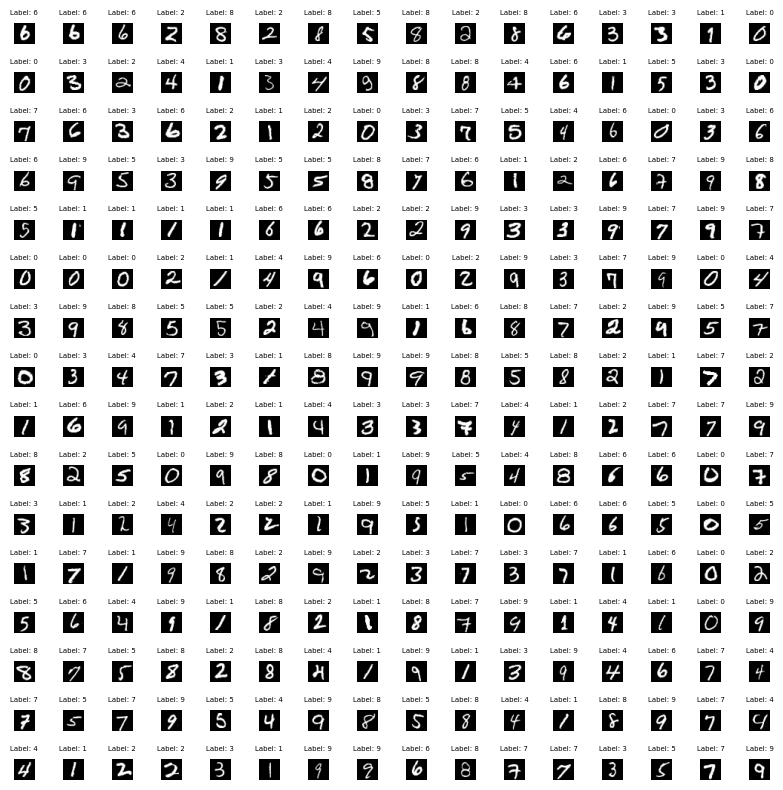

In [4]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Plot the first 16 images in a 4x4 grid
plt.figure(figsize=(8,8))
for i in range(BATCH_SIZE):
    plt.subplot(int(math.sqrt(BATCH_SIZE)), int(math.sqrt(BATCH_SIZE)), i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Label: {labels[i].item()}", fontsize=5)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
#Helpful functions

def graph_image(image, label=torch.tensor(0), graph_center = False, graph_point=None):
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label.item()}", fontsize=10)
    width = image[0].size(1)
    height = image[0].size(0)
    if graph_center:
        plt.plot(width/2, height/2,  marker='o', markersize=5, color='red', label = "Center of image")
    if graph_point is not None:
        plt.plot(graph_point[0], graph_point[1], marker='o', markersize=5, color='blue', label = "Center of brightness")
    if graph_center or graph_point is not None:
        plt.legend()
    plt.show()
    
def graph_images(images,  labels = None, graph_points = None, graph_centers = False, figure_size=100):
    plt.figure(figsize=(figure_size,figure_size))
    for i in range(len(images)):
        image = images[i]
        plt.subplot(int(math.sqrt(BATCH_SIZE)), int(math.sqrt(BATCH_SIZE)), i + 1)
        plt.imshow(image.squeeze(), cmap="gray")
        if labels is not None:
           label = labels[i]
           plt.title(f"{label}", fontsize = figure_size/4)
        width = image[0].size(1)
        height = image[0].size(0)
        if graph_centers:
            plt.plot(width/2, height/2,  marker='o', markersize=figure_size/20, color='red', label = "Center of image")
        if graph_points is not None:
            graph_point = graph_points[i]
            plt.plot(graph_point[0], graph_point[1], marker='o', markersize=5, color='blue', label = "Center of brightness")
            
        if graph_centers or graph_points is not None:
            plt.legend(fontsize = figure_size/10)
        plt.axis("off")
    plt.show()



def generate_box_image(sample_image):
    new_image = torch.zeros_like(sample_image)
    for i in range(new_image.size(1)):
        for j in range(new_image.size(2)):
            if (i == 10 or i == 20) and (j < 20 and j > 10):
                new_image[0][i][j] = 1
            if (j == 10 or j == 20) and (i < 20 and i > 10):
                new_image[0][i][j] = 1
    return new_image


Original dataset is already centered at the center of brightness, so we will add some noise to show how the SVD decreases as if they were not centered

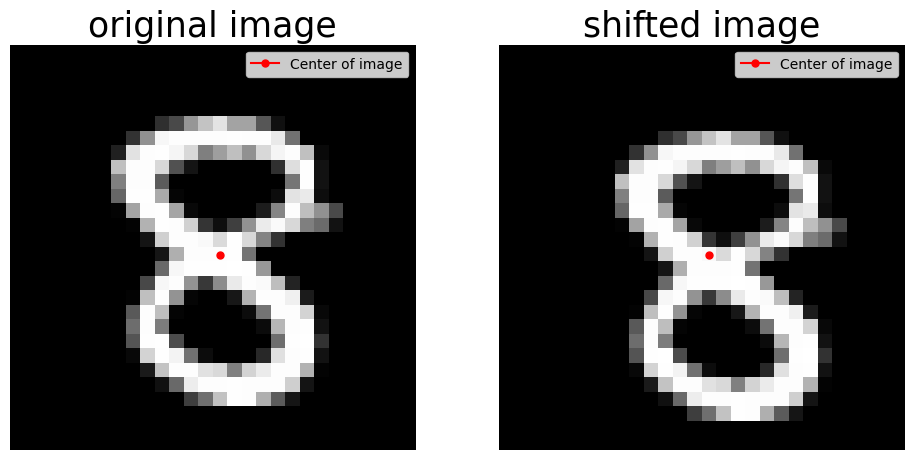

In [7]:
def shift(image, diff):
    rolled_img = torch.roll(image, (int(diff[0].item()), int(diff[1].item())), dims=(2,1))
    return rolled_img

rshifted_images = []
for image in images:
    rshifted_images.append(shift(image, torch.rand(2)*5))
    
rshifted_images = torch.stack(rshifted_images)

graph_images([images[4],rshifted_images[4]],labels=["original image", "shifted image"], graph_centers=True, figure_size=100)

Start translating the images


In [11]:
def recenter(image,new_center):
    width = image[0].size(1)
    height = image[0].size(0)
    original_center = torch.tensor([height/2,  width/2])
    diff = original_center - new_center
    return shift(image, diff)


computed center of brightness: tensor([14.2383, 13.8562])


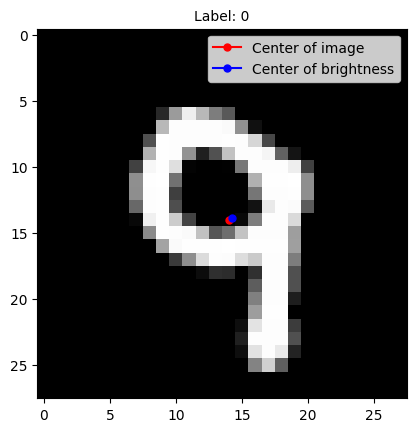

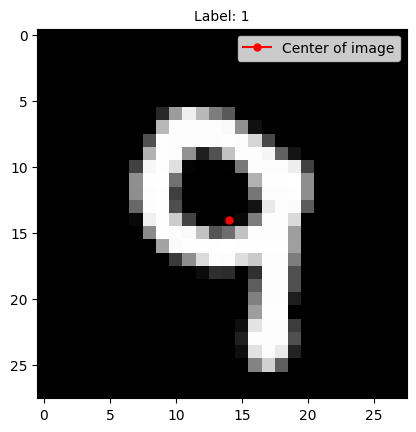

In [12]:
def find_center_of_brightness(image):
    center = torch.tensor([0.0,0.0])
    for i in range(image.size(1)):
        for j in range(image.size(2)):
            center +=  image[0][i][j]*torch.tensor([j,i])    
    center = center / torch.sum(image[0])
    return center


center_of_brightness = find_center_of_brightness(image)
print("computed center of brightness: " + str(center_of_brightness))

recentered_image = recenter(image, center_of_brightness)
graph_image(image, label=torch.tensor([0]), graph_center=True, graph_point = center_of_brightness)
graph_image(recentered_image, label=torch.tensor([1]), graph_center=True)

Apply transformation to all images

In [15]:
centering_func = lambda img: recenter(img, find_center_of_brightness(img))

In [16]:
recentered_images = []
for image in images:
    recentered_images.append(centering_func(image))

recentered_images = torch.stack(recentered_images)

Preform SVD decomposition on the noisy data and the recentered data

In [17]:
#SVD functions

def get_SVD_vals(images):
    flattened_images = images.flatten(start_dim=1)
    U, svd_vals, V = svd(flattened_images)
    return svd_vals

def get_SVD_decomp(images):
    flattened_images = images.flatten(start_dim=1)
    U, svd_vals, V = svd(flattened_images)
    return U, svd_vals, V

def graph_SVDs(svd_vals, labels = None, title = None):
    #print(type(svd_vals))
    if type(svd_vals) is list:
        for svds, label in zip(svd_vals, labels):
            #print("svds", svds)
            x_vals = [i+1 for i in range(len(svds))]
            plt.plot(x_vals, svds, label = label, alpha = 0.5)
    else:
        x_vals = [i+1 for i in range(len(svd_vals))]
        plt.plot(x_vals, svd_vals)
    if title is not None:
        plt.title(title)
    plt.yscale("log")
    plt.legend()
    plt.show()


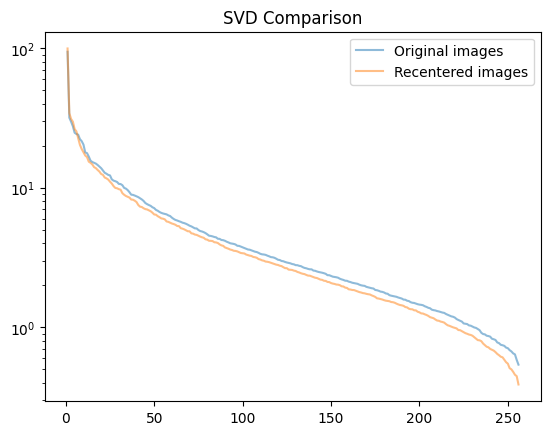

In [18]:
osvds = get_SVD_vals(rshifted_images)
svdr=get_SVD_vals(recentered_images)
graph_SVDs([osvds, svdr], ["Original images", "Recentered images"],title="SVD Comparison")